In [1]:
# Импорт необходимых библиотек
import pandas as pd

import pickle
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.neural_network import MLPClassifier

In [2]:
# Загрузка таблицы и вывод её первых пяти строк
df = pd.read_csv('df_out.csv')
print('Размерность:',df.shape)
df.head()

Размерность: (10000, 20)


,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020.0,ram,2500 crew cab big horn,diesel,27442,clean,other,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,2021-04-17T12:30:50-0400,high,2021-04-17 16:30:50+00:00
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016.0,ford,explorer 4wd 4dr xlt,NaN,60023,clean,automatic,https://images.craigslist.org/00x0x_26jl9F0cnL...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017.0,volkswagen,golf r hatchback,gas,14048,clean,other,https://images.craigslist.org/00y0y_eeZjWeiSfb...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,2021-04-28T03:52:20-0700,high,2021-04-28 10:52:20+00:00
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013.0,toyota,rav4,gas,117291,clean,automatic,https://images.craigslist.org/00606_iGe5iXidib...,2013 Toyota RAV4 XLE 4dr SUV Offered by: R...,nc,35.715954,-78.655304,2021-04-17T10:08:57-0400,medium,2021-04-17 14:08:57+00:00
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021.0,nissan,altima,gas,8000,clean,automatic,https://images.craigslist.org/00V0V_3pSOiPZ3Sd...,2021 Nissan Altima Sv with Only 8 K Miles Titl...,ny,40.654800,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00


#  Data Preparation

### Data Cleaning, Работа с пропусками

In [3]:
# Проверка данных на наличие пропусков
df.isna().sum().sort_values(ascending=False)

title_status      166
model             128
long               98
lat                98
fuel               63
transmission       45
year               36
posting_date        2
description         2
image_url           2
date                2
url                 0
odometer            0
manufacturer        0
state               0
price               0
region_url          0
region              0
price_category      0
id                  0
dtype: int64

In [4]:
# Создание таблицы с перечислением колонок и количества пропусков в них для создания графика
df_isna = pd.DataFrame()
df_isna['columns'] = df.columns
df_isna['isna'] = df.isna().sum().tolist()

Text(0.5, 1.0, 'Пропуски в признаках')

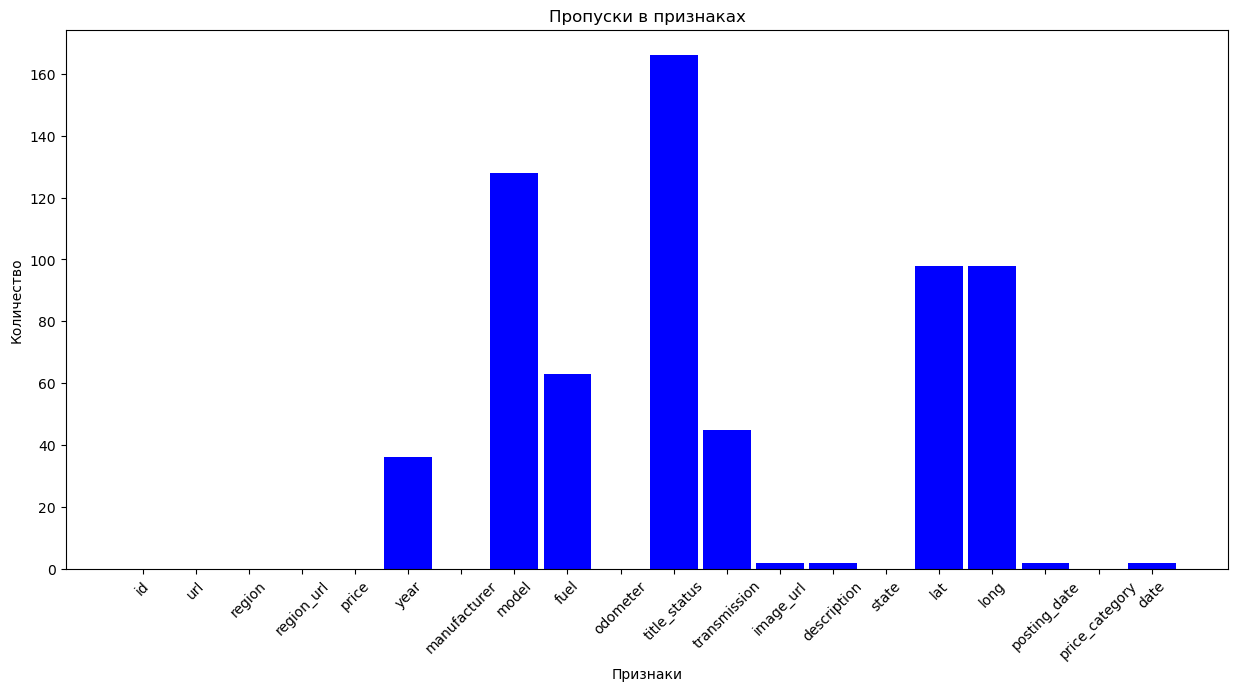

In [5]:
# Построение графика количества пропусков по колонкам 
plt.figure(figsize = (15, 7))
plt.bar(df_isna['columns'], df_isna['isna'], width = 0.9, color = ['blue'])
plt.xlabel('Признаки')
plt.xticks(rotation = 45)
plt.ylabel('Количество')
plt.title('Пропуски в признаках')

In [6]:
# Замена пропусков в колонках title_status, long и lat на самые популярные их значения
df.title_status = df.title_status.fillna(df.title_status.mode()[0])
df.long = df.long.fillna(df.long.mode()[0])
df.lat = df.lat.fillna(df.lat.mode()[0])
# Замена пропусков в колонках model, fuel, и transmission на значение 'other'
df[['model', 'fuel', 'transmission']] = df[['model', 'fuel', 'transmission']].fillna('other')
# Удаление строк с пропусками в колонке year
df = df[df.year.notna()]

In [7]:
# Повторная проверка на наличие пропусков для утверждения их отсутствия
df.isna().sum().sort_values(ascending=False)

id                0
url               0
price_category    0
posting_date      0
long              0
lat               0
state             0
description       0
image_url         0
transmission      0
title_status      0
odometer          0
fuel              0
model             0
manufacturer      0
year              0
price             0
region_url        0
region            0
date              0
dtype: int64

###  Data Cleaning, Приведение типов

In [8]:
# Приведение к типу целого числа
df.year = df.year.astype(int)
# Приведение к типу категория
df[['fuel', 'title_status', 'transmission', 'price_category']] = df[['fuel', 'title_status', 'transmission', 'price_category']].astype('category')
# Приведение к типу числа с плавающей точкой
df[['lat', 'long']] = df[['lat', 'long']].astype(float)
# Приведение к дата/время типу
df.posting_date = pd.to_datetime(df.posting_date, utc = True)
df.date = pd.to_datetime(df.date, utc = True)

In [9]:
# Проверка типов признаков
df.dtypes

id                              int64
url                            object
region                         object
region_url                     object
price                           int64
year                            int32
manufacturer                   object
model                          object
fuel                         category
odometer                        int64
title_status                 category
transmission                 category
image_url                      object
description                    object
state                          object
lat                           float64
long                          float64
posting_date      datetime64[ns, UTC]
price_category               category
date              datetime64[ns, UTC]
dtype: object

### Data Cleaning, Удаление аномалий

Text(0.5, 1.0, 'Проверка аномалий, пробег')

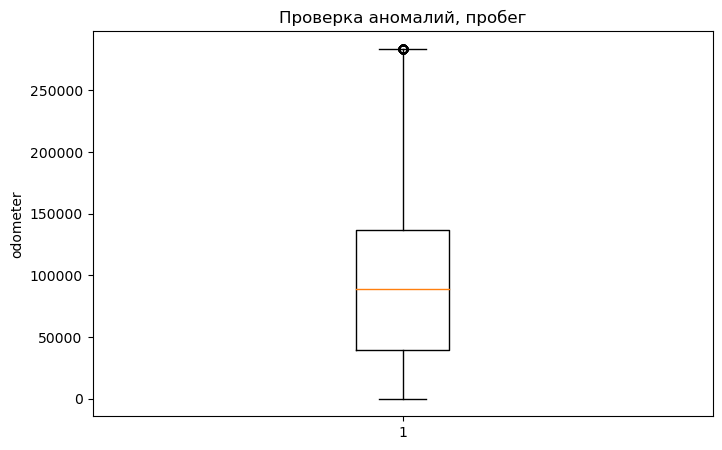

In [10]:
# Построение "ящика с усами" для проверки аномалий в колонке odometer
plt.figure(figsize = (8, 5))
plt.boxplot(df.odometer)
plt.ylabel('odometer')
plt.title('Проверка аномалий, пробег')

Text(0.5, 1.0, 'Проверка аномалий, год')

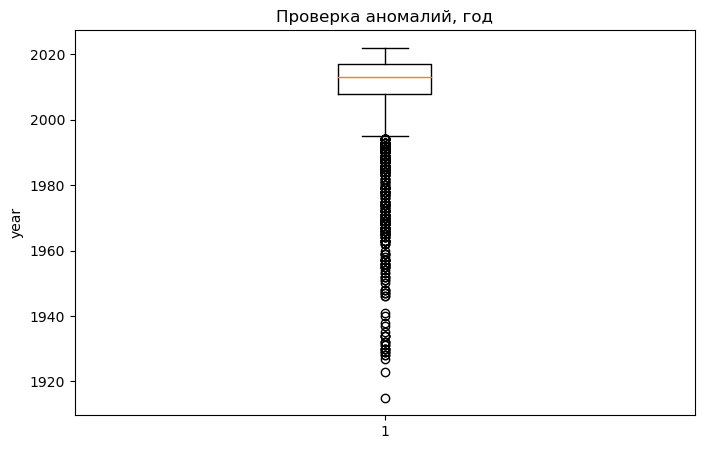

In [11]:
# Построение "ящика с усами" для проверки аномалий в колонке year
plt.figure(figsize = (8, 5))
plt.boxplot(df.year)
plt.ylabel('year')
plt.title('Проверка аномалий, год')

In [12]:
# Применение межквартильного размаха, функция для его определения
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries
# Вывод максимального и минимального значений для колонки odometer
boundaries_odometer = calculate_outliers(df.odometer)
boundaries_odometer

(-107050.625, 283430.375)

In [13]:
# Вывод количества значений находящихся за пределами межквартильного размаха
is_outlier_odometer = (df.odometer < boundaries_odometer[0]) | (df.odometer > boundaries_odometer[1]) 
is_outlier_odometer.sum()

91

In [14]:
# Вывод максимального и минимального значений для колонки year
boundaries_year = calculate_outliers(df.year)
boundaries_year

(1994.5, 2030.5)

In [15]:
# Вывод количества значений находящихся за пределами межквартильного размаха
is_outlier_year = (df.year < boundaries_year[0]) | (df.year > boundaries_year[1]) 
is_outlier_year.sum()

394

In [16]:
# Так как значения за пределами выше максимального допустимого значения, то они приравниваются к нему
df.loc[is_outlier_odometer, 'odometer'] = int(boundaries_odometer[1])
# Значения ниже минимального, приравниваются к нему
df.loc[is_outlier_year, 'year'] = int(boundaries_year[0])

Text(0.5, 1.0, 'Проверка аномалий, пробег')

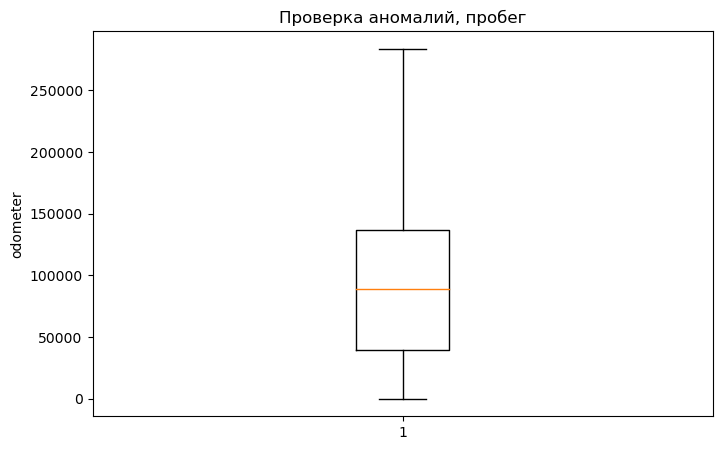

In [17]:
# Построение "ящика с усами" для проверки отсутствия аномалий в колонке odometer
plt.figure(figsize = (8, 5))
plt.boxplot(df.odometer)
plt.ylabel('odometer')
plt.title('Проверка аномалий, пробег')

Text(0.5, 1.0, 'Проверка аномалий, год')

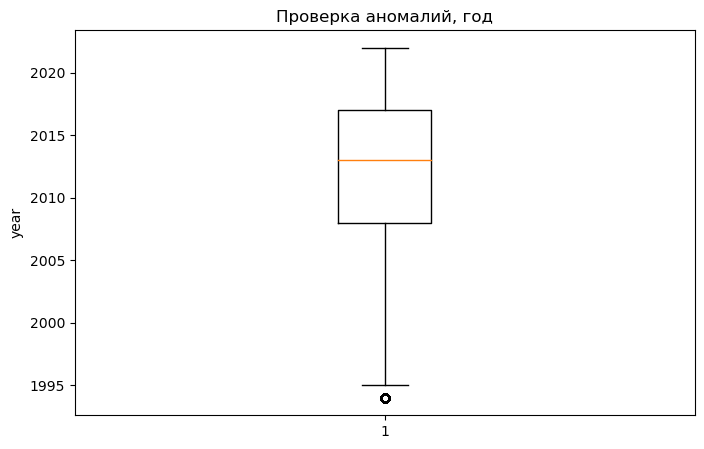

In [18]:
# Построение "ящика с усами" для проверки отсутствия аномалий в колонке year
plt.figure(figsize = (8, 5))
plt.boxplot(df.year)
plt.ylabel('year')
plt.title('Проверка аномалий, год')

#  Feature engineering

###  Формирование новых признаков

In [19]:
# Формирование новых признаков на основе:
# выведения первого слова
df['short_model'] = df.model.apply(lambda x : x.split(' ')[0])
# подсчёта количества слов
df['desc_word_count'] = df.apply(lambda x : len(x.description.split(' ')), axis = 1)
# выведения названия региона из URL объявления
df['region_in_url'] = df.url.apply(lambda x : x.split('://')[1].split('.')[0])
# дат
df['day'] = df.date.dt.day
df['month'] = df.date.dt.month
df['diff_years'] = df.date.dt.year - df.year
# подсчёта количества символов
df['model_len'] = df.apply(lambda x : len(x.model), axis = 1)
df['manuf_len'] = df.apply(lambda x : len(x.manufacturer), axis = 1)
# выведения категории 
df['age_category'] =  df.apply(lambda x : 'new' if x.year > 2013 else ('old' if x.year < 2006 else 'average'), axis=1)
df['odometer_category'] =  df.apply(lambda x : 'new' if x.odometer < 40000 else ('old' if x.odometer > 140000 else 'average'), axis=1)

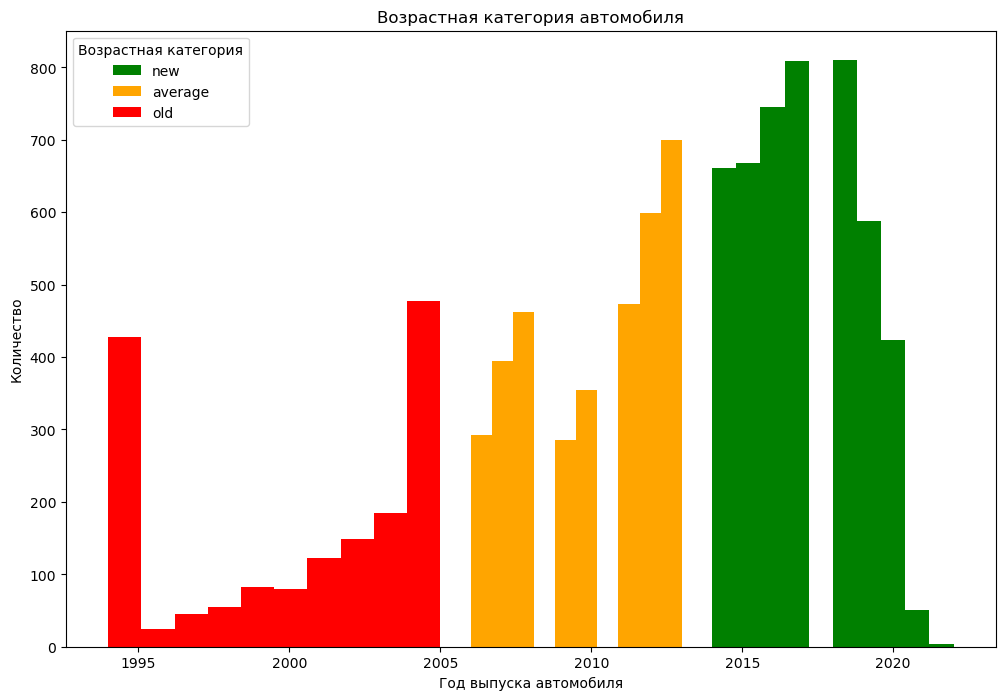

In [20]:
# Построение графика возростных категорий автомобилей
colors = {'new': 'green', 'average': 'orange', 'old': 'red'}
fig, ax = plt.subplots(figsize = (12, 8))
for age_category in colors:
    color = colors[age_category]
    data = df[df['age_category'] == age_category]
    ax.hist(data['year'], color = color)
plt.ylabel('Количество')
plt.xlabel('Год выпуска автомобиля')
plt.title('Возрастная категория автомобиля')
plt.legend(colors, title = 'Возрастная категория');

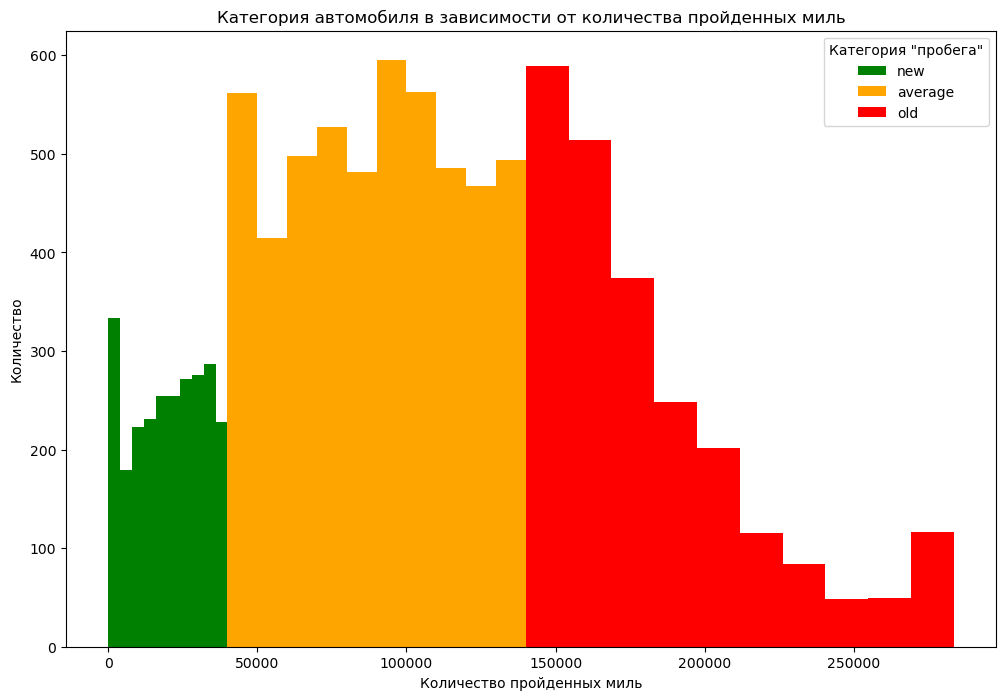

In [21]:
# Построение графика категорий пробега автомобилей
colors = {'new': 'green', 'average': 'orange', 'old': 'red'}
fig, ax = plt.subplots(figsize = (12, 8))
for odometer_category in colors:
    color = colors[odometer_category]
    data = df[df['odometer_category'] == odometer_category]
    ax.hist(data['odometer'], color = color)
plt.ylabel('Количество')
plt.xlabel('Количество пройденных миль')
plt.title('Категория автомобиля в зависимости от количества пройденных миль')
plt.legend(colors, title = 'Категория "пробега"');

###  Преобразование категориальных данных

In [23]:
# Создание новой таблицы с категориальными переменными
data = df[['short_model', 'transmission', 'region', 'manufacturer', 'state', 'title_status', 'fuel', 'region_in_url', 
           'age_category', 'odometer_category']]
# Создание переменной 
ohe = OneHotEncoder(sparse = False)
# Идентификация параметров
ohe.fit(data)
# Применение преобразований
ohe_data = ohe.transform(data)
# Формирование названий новых колонок
ohe.get_feature_names_out()
# Добавление новых колонок в основную таблицу
df[ohe.get_feature_names_out()] = ohe_data
# Вывод размера и матрицы сформированных колонок
print(ohe_data.shape)
print(ohe_data)

(9964, 1877)
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


###  Нормализация данных

In [24]:
# Создание новой таблицы с числовыми данными
data1 = df[['year', 'odometer', 'lat', 'long', 'desc_word_count', 'model_len', 'manuf_len', 'day', 'month', 'diff_years']]
# Создание переменной 
std_scaler = StandardScaler()
# Идентификация параметров
std_scaler.fit(data1)
# Применение преобразований
std_scaler_data1 = std_scaler.transform(data1)
# Формирование названий новых колонок с добавлением отличительного окончания _std
std_scaler.get_feature_names_out() + '_std'
# Добавление новых колонок в основную таблицу
df[std_scaler.get_feature_names_out() + '_std'] = std_scaler_data1
# Вывод размера и матрицы сформированных колонок
print(std_scaler_data1.shape)
print(std_scaler_data1)

(9964, 10)
[[ 1.27835384 -1.04791402 -0.61478519 ...  0.16788131 -0.61230201
  -1.27835384]
 [ 0.66454194 -0.53174822  0.37278145 ... -1.21449112  1.63318097
  -0.66454194]
 [ 0.81799491 -1.260109   -0.83431041 ...  1.25403108 -0.61230201
  -0.81799491]
 ...
 [-0.10272294  0.89663103  1.0762199  ...  0.66158575 -0.61230201
   0.10272294]
 [ 0.51108896 -0.50133054  0.7511879  ... -0.12834135 -0.61230201
  -0.51108896]
 [ 0.81799491 -0.91358512 -0.33883307 ...  0.85906753 -0.61230201
  -0.81799491]]


###  Формирование финального датасета

In [25]:
# Подготовка переменной с списком колонок для удаления из основной таблицы
columns_drop = ['url', 'region', 'region_url', 'manufacturer', 'model', 'image_url', 'description', 'state', 'short_model',
                'fuel', 'title_status', 'transmission', 'year', 'odometer', 'lat', 'long', 'posting_date', 'date', 'id',
                'price', 'model_len', 'desc_word_count', 'region_in_url', 'age_category', 'odometer_category', 'manuf_len',
                'day', 'month', 'diff_years']
# Удаление ненужных колонок
df_prepared = df.drop(columns = columns_drop)
print(df_prepared.shape)
df_prepared.head()

(9964, 1888)


,price_category,short_model_-benz,short_model_1,short_model_124,short_model_128i,short_model_135i,short_model_1500,short_model_163869,short_model_1928,short_model_1951,...,year_std,odometer_std,lat_std,long_std,desc_word_count_std,model_len_std,manuf_len_std,day_std,month_std,diff_years_std
0,high,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.278354,-1.047914,-0.614785,0.486506,0.476491,1.157270,-1.186797,0.167881,-0.612302,-1.278354
1,medium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.664542,-0.531748,0.372781,1.105610,-0.680605,0.927064,-0.758470,-1.214491,1.633181,-0.664542
2,high,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.817995,-1.260109,-0.834310,0.532889,0.413377,0.466651,1.811490,1.254031,-0.612302,-0.817995
3,medium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.204183,0.375522,-0.502355,0.851432,0.046166,-0.914588,0.098183,0.167881,-0.612302,-0.204183
4,medium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.431807,-1.355925,0.344157,1.130637,-0.739894,-0.684381,0.098183,-1.214491,1.633181,-1.431807


#  Modelling

###  Подготовка

In [26]:
# Подготовка фичей и целевой переменной
x = df_prepared.drop(['price_category'], axis=1)
y = df_prepared['price_category']
# Разделение данных на train и test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

###  Логистическая регрессия

In [27]:
# Применяем логистическую регрессию
logreg = LogisticRegression(random_state=42, C=10, intercept_scaling=15, max_iter=200, multi_class='multinomial', solver='newton-cg')
# Обучаем модель
logreg.fit(x_train, y_train)
# Предсказываем, применяем модель
logreg_test = logreg.predict(x_test)
# Выводим процент верных предсказаний
accuracy_score(y_test, logreg_test)

0.7842809364548495

In [28]:
# Применяем кросс-валидацию для обнаружения переобучения
cross_val_score(logreg, x, y, cv=5)

array([0.78725539, 0.78023081, 0.77872554, 0.78123432, 0.7751004 ])

###  Случайный лес

In [49]:
# Применяем модель случайного леса
rf_clf = RandomForestClassifier(random_state=42, bootstrap=False, class_weight='balanced', min_samples_split=2, n_estimators=50)
# Обучаем модель
rf_clf.fit(x_train, y_train)
# Предсказываем, применяем модель
rf_clf_test = rf_clf.predict(x_test)
# Выводим процент верных предсказаний
accuracy_score(y_test, rf_clf_test)

0.7899665551839465

In [50]:
# Применяем кросс-валидацию для обнаружения переобучения
cross_val_score(rf_clf, x, y, cv=5)

array([0.77521325, 0.76869042, 0.77069744, 0.78575013, 0.77259036])

###  Многослойный персептрон

In [81]:
# Применяем модель многослойного персептрона
mlp_clf = MLPClassifier(random_state = 42, activation='logistic', hidden_layer_sizes=25, max_iter=120, solver='adam')
warnings.filterwarnings('ignore')
# Обучаем модель
mlp_clf.fit(x_train, y_train)
# Предсказываем, применяем модель
mlp_clf_test = mlp_clf.predict(x_test)
# Выводим процент верных предсказаний
accuracy_score(y_test, mlp_clf_test)

0.7903010033444816

In [82]:
# Применяем кросс-валидацию для обнаружения переобучения
cross_val_score(mlp_clf, x, y, cv=5)

array([0.80280983, 0.7997993 , 0.79528349, 0.78123432, 0.79618474])

###  График результатов моделирования

In [83]:
# Создание новой таблицы для построения графика
df_mod = pd.DataFrame()
df_mod['columns'] = 'Логистическая_регрессия', 'Случайный_лес', 'Многослойный_персептрон'
df_mod['results'] = accuracy_score(y_test, logreg_test)*100, accuracy_score(y_test, rf_clf_test)*100, accuracy_score(y_test, mlp_clf_test)*100

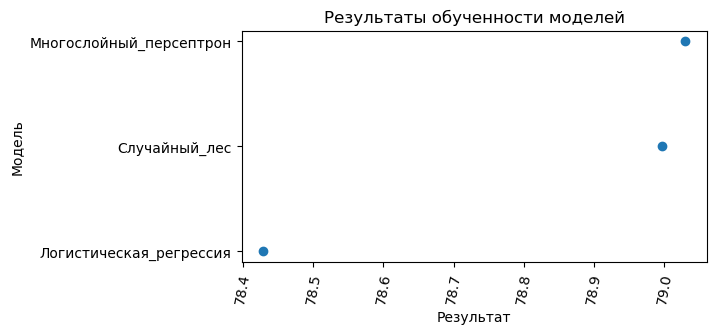

In [84]:
# Построение графика сравнения результатов обученных моделей
plt.figure(figsize = (6, 3))
plt.scatter(df_mod['results'], df_mod['columns'])
plt.title('Результаты обученности моделей')
plt.xlabel('Результат')
plt.xticks(rotation = 80)
plt.ylabel('Модель')
plt.show()

#  Results

Модель многослойного персептрона показала лучший результат

In [85]:
# Обучение лучшей модели на всей таблице
mlp_clf.fit(x, y)

MLPClassifier(activation='logistic', hidden_layer_sizes=25, max_iter=120,
              random_state=42)

In [86]:
# Сохранение обученной модели в pickle
filename = 'mlp_clf_pickle.pickle'
with open (filename, 'wb') as file:
    pickle.dump(mlp_clf, file)